<a href="https://colab.research.google.com/github/dgmyaing/labs/blob/main/PCA_Lab_First_Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


To clean the data, I got rid of "stop words" like punctuation, super common words like "and" or "the," and numbers. Then I one-hot-encoded the tokens to turn them into features for each email. After that, I used algorithms to predict if the emails were scams based on the presence of these tokens.

In [5]:
from google.colab import files
uploaded = files.upload()

with open('all_tokens (2).pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Saving all_tokens (2).pickle to all_tokens (2) (1).pickle


<Axes: >

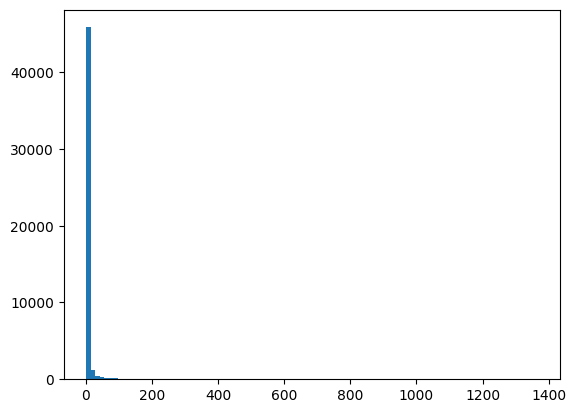

In [6]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [7]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


The token distribution is super skewed: most tokens show up only once, and only a few appear more than 10 times. Even at the 75th percentile, tokens only show up twice, while the most common token appears 1,365 times. This creates some issues: tokens that barely show up aren't useful for predicting scams, and super common ones, like "the" or "and," don’t add much value either.

In [11]:
from google.colab import files
uploaded = files.upload()




Saving Phishing_clean.parquet to Phishing_clean (2).parquet


In [13]:
df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

## 2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [14]:
## 3.

rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The top variables are just numbers; though not necesarily making the scams more obvious, this does highlight the value of using PCA.

The model performs pretty well on the training set with a score of 0.62 R^2. However, on the test set, it’s barely better than predicting the mean. This points to overfitting, which isn’t surprising given the 2,611 features that are likely highly correlated.

<Axes: >

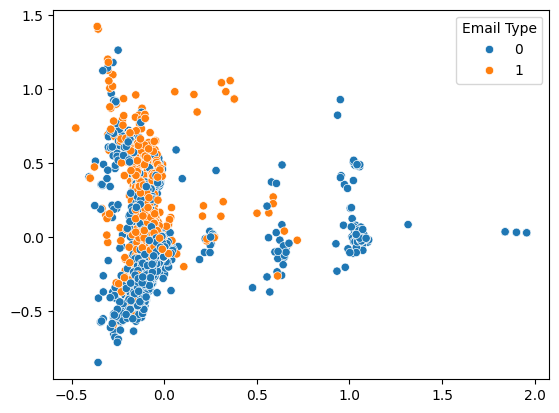

In [15]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The orange dots are the scam points. They tend to have a high second component and low first component. The model essentially helps us separate the orange and blue dots

In [16]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


This performs much better: we see a 0.587 R^2 instead of 0 from the linear model, and it's much coser to the 0.692 R^2

Because the features/covariates are made independent/orthogonal by way of the PCA decomposition, multi-colinearity doesn't arise. It's also easier to decide whether to include 1, 2, ..., 2711 components, rather than 2^2711 possible packages of components.